In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from scipy import stats
import matplotlib.dates as mdates
from datetime import datetime
from iminuit import Minuit
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/Data/MA200/Raw data/visibuilt_day1 2024/'
path_field = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/cph central and nørreport measurements/'
path_screening = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/pilot kbh hovedbanegaard and noerregade/rawdata/particle/ma200/'

data = read_csv_BC(path, parent_path, 0)

HEPA_keys = ['MA200-0285_240910101601', 'MA200-0353_240910103200', 'MA200-0369_240910101605']
conc_keys = ['Sample temp (C)', 'Sample RH (%)', 'Sample dewpoint (C)', 
             'UV BCc', 'Blue BCc', 'Green BCc', 'Red BCc', 'IR BCc']
ylabels = ['Sample T / $^{\circ}$C', 'Sample RH / %', 'Sample DP / $^{\circ}$C', 
           'UV BC / $\mu$g m$^{-3}$', 'Blue BC / $\mu$g m$^{-3}$', 'Green BC / $\mu$g m$^{-3}$', 
           'Red BC / $\mu$g m$^{-3}$', 'IR BC / $\mu$g m$^{-3}$']
colors = ['tab:red', 'tab:blue', 'tab:cyan', 'darkviolet', 'blue', 'green', 'red', 'k']
line_styles = ['-', ':', '--']

mask = data['MA200-0285_240910101601']['IR BCc'] < 1
data['MA200-0285_240910101601'] = data['MA200-0285_240910101601'][mask]

field1 = read_csv_BC(f'{path_field}/Station 1/MA200/', parent_path, -1)
field2 = read_csv_BC(f'{path_field}/Station 2/MA200/', parent_path, -1)
screening = read_csv_BC(path_screening, parent_path, 0)

field1['MA200-0369_241217094901'] = pd.concat([field1['MA200-0369_241217094901'], field1['MA200-0369_241217101259']], ignore_index=True)

field1_keys = ['MA200-0369_000301200101', 'MA200-0369_241210105000', 'MA200-0369_241211095501', 'MA200-0369_241212094705', 
               'MA200-0369_241213094000', 'MA200-0369_241216103300', 'MA200-0369_241217094901']
field2_keys = ['MA200-0285_241209120400', 'MA200-0285_241210105200', 'MA200-0285_241211093400', 'MA200-0285_241212093100', 
               'MA200-0285_241213092900', 'MA200-0285_241216102104', 'MA200-0285_241217101400']
screening_keys = ['MA200-0285_240917110800', 'MA200-0369_240917110806', 'MA200-0369_240919114800']

c:\Users\B363580\Documents\GitHub\Master-thesis\calibration\..\plot_functions.py:265: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
C:\Users\B363580\AppData\Local\Temp\ipykernel_4028\4200447559.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


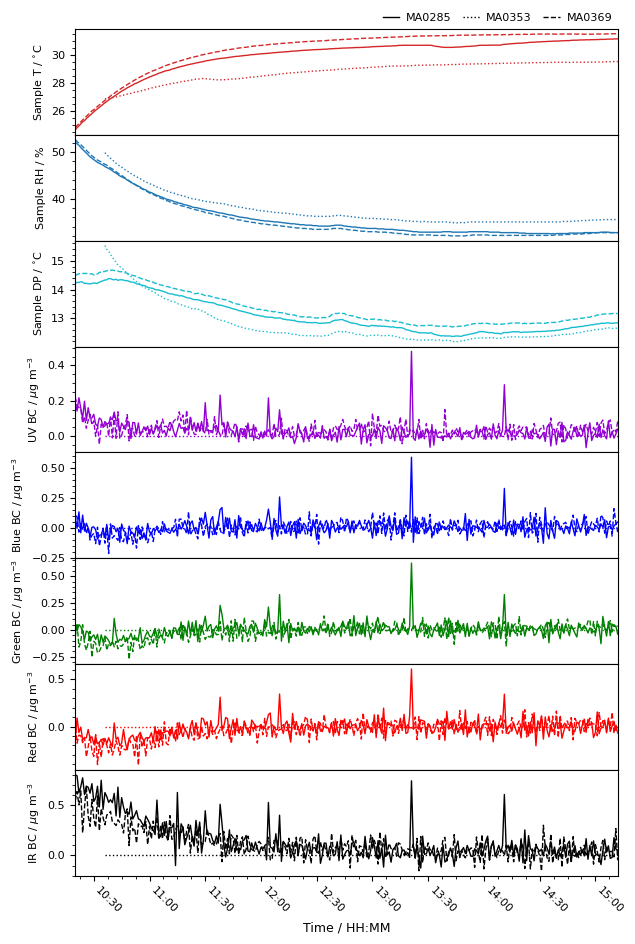

In [3]:
fig = plt.figure(figsize = (7, 11))
gs = fig.add_gridspec(8, hspace=0)
ax = gs.subplots(sharex=True)

for i, df_key in enumerate(conc_keys):
    for ls, dict_key in zip(line_styles, HEPA_keys):
        plot_total(ax[i], data[dict_key], df_key, colors[i], ls)
        ax[i].set_ylabel(ylabels[i], fontsize = 8)

ax[7].legend(labels = ['MA0285', 'MA0353', 'MA0369'], bbox_to_anchor = (0, 7.2, 1, 1), ncol = 3, fontsize = 8)

fig.tight_layout()
fig.savefig('MA200/HEPA_timeseries.pdf', dpi = 600)

In [4]:
start, end = '2024-09-10 12:14:00', '2024-09-10 13:16:00'

for key, MA in zip(HEPA_keys, ['MA0285', 'MA0353', 'MA0369']):
    print(MA)
    df = data[key]
    time_filter = (df['Time'] >= start) & (df['Time'] <= end)
    for BC in conc_keys[3:]:
        STD = df[BC][time_filter].std()
        LOD = 3*STD
        print(f'{BC}: std = {STD}, LOD = {LOD}')

MA0285
UV BCc: std = 0.03150663743983126, LOD = 0.09451991231949378
Blue BCc: std = 0.04796839290480705, LOD = 0.14390517871442116
Green BCc: std = 0.048733309798032066, LOD = 0.1461999293940962
Red BCc: std = 0.06692309362865329, LOD = 0.20076928088595986
IR BCc: std = 0.07318855279422219, LOD = 0.21956565838266656
MA0353
UV BCc: std = 0.0, LOD = 0.0
Blue BCc: std = 0.0, LOD = 0.0
Green BCc: std = 0.0, LOD = 0.0
Red BCc: std = 0.0, LOD = 0.0
IR BCc: std = 0.0, LOD = 0.0
MA0369
UV BCc: std = 0.035499601549728026, LOD = 0.10649880464918407
Blue BCc: std = 0.057172487197696, LOD = 0.171517461593088
Green BCc: std = 0.04841380027789257, LOD = 0.1452414008336777
Red BCc: std = 0.07202373449615877, LOD = 0.2160712034884763
IR BCc: std = 0.08241599860098053, LOD = 0.2472479958029416


In [5]:
for key in HEPA_keys:
    print(key)
    print(min(data[key]['Sample dewpoint (C)']), max(data[key]['Sample dewpoint (C)']))

MA200-0285_240910101601
12.37 14.38
MA200-0353_240910103200
12.19 15.53
MA200-0369_240910101605
12.7 14.68


In [6]:
for key1, key2 in zip(field1_keys, field2_keys):
    print(key1)
    print(min(field1[key1]['Sample dewpoint (C)']), max(field1[key1]['Sample dewpoint (C)']))

    print(key2)
    print(min(field2[key2]['Sample dewpoint (C)']), max(field2[key2]['Sample dewpoint (C)']))

MA200-0369_000301200101
-4.4 0.29
MA200-0285_241209120400
-4.62 -0.22
MA200-0369_241210105000
-0.72 2.8
MA200-0285_241210105200
-3.49 -0.19
MA200-0369_241211095501
-1.78 3.56
MA200-0285_241211093400
-7.88 0.05
MA200-0369_241212094705
-0.81 3.13
MA200-0285_241212093100
-3.85 -1.39
MA200-0369_241213094000
-0.68 2.9
MA200-0285_241213092900
-3.67 0.03
MA200-0369_241216103300
0.68 5.48
MA200-0285_241216102104
1.78 4.43
MA200-0369_241217094901
1.21 5.75
MA200-0285_241217101400
0.89 5.01


MA0285
UV BCc
[-0.01865048  0.5882375 ] 0.22967927510745823
[0.04126308 1.23457598]
[0.74653855 0.01364249] 0.20776616665470868
[1.76293271 0.07058543]
Blue BCc
[ 0.00528158 -0.14881796] 0.01247523839187993
[0.04126309 1.23457613]
[-0.30725857  0.015588  ] 0.023258578858764114
[1.76293271 0.07058543]
Green BCc
[ 0.01494542 -0.44673415] 0.08141028965023273
[0.04126309 1.23457612]
[-0.63243837  0.01398806] 0.07987128862199182
[1.76293271 0.07058543]
Red BCc
[ 0.02770034 -0.84656803] 0.17106297930948067
[0.04126309 1.23457628]
[-1.14876975  0.00726981] 0.1618737063325981
[1.76293271 0.07058543]
IR BCc
[-0.11865437  3.69795971] 0.7157600274309929
[0.04126309 1.23457609]
[4.90600002 0.04022357] 0.6955018162527711
[1.76293271 0.07058543]
MA0369
UV BCc
[-0.00852226  0.29757044] 0.10852013239062341
[0.0376792  1.14757984]
[0.29815111 0.03088825] 0.07131340956252882
[1.68783719 0.07014288]
Blue BCc
[ 0.01301784 -0.39168835] 0.11272001029435395
[0.03767919 1.14757975]
[-0.65437675  0.01891363] 0

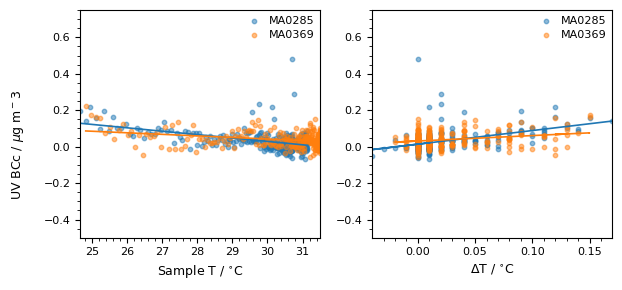

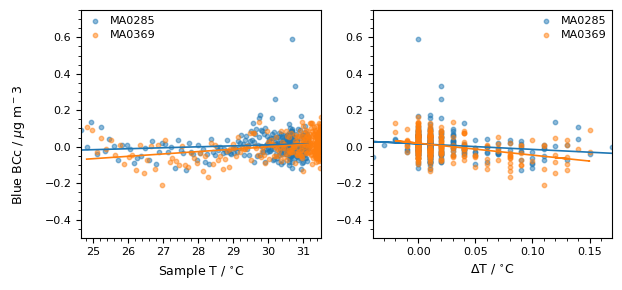

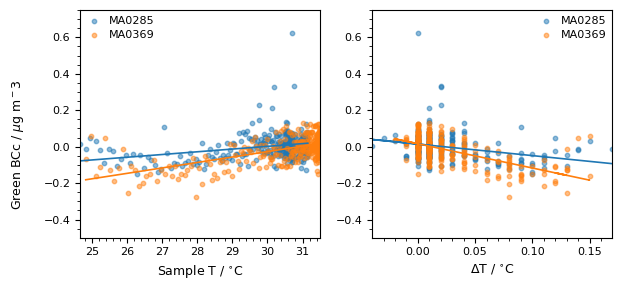

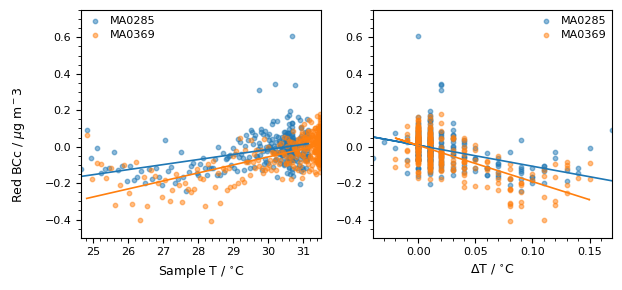

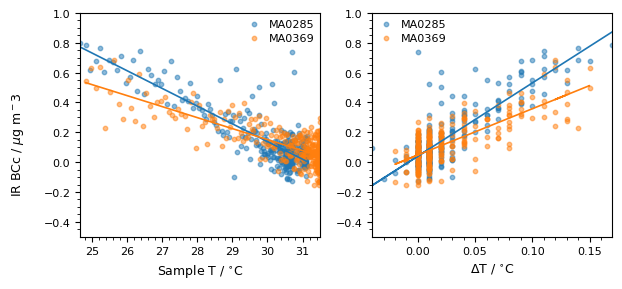

In [4]:
x_labels = ['Sample T / $^{\circ}$C','$\Delta$T / $^{\circ}$C']
guess = [-0.11, 3.45]

fig_UV, axs_UV = plt.subplots(1, 2, figsize = (6.3, 3))
fig_blue, axs_blue = plt.subplots(1, 2, figsize = (6.3, 3))
fig_green, axs_green = plt.subplots(1, 2, figsize = (6.3, 3))
fig_red, axs_red = plt.subplots(1, 2, figsize =(6.3, 3))
fig_IR, axs_IR = plt.subplots(1, 2, figsize = (6.3, 3))
figs = [fig_UV, fig_blue, fig_green, fig_red, fig_IR]
axes = [axs_UV, axs_blue, axs_green, axs_red, axs_IR]

MA0285_a = []
MA0285_b = []
MA0369_a = []
MA0369_b = []

for key, lbl in zip([HEPA_keys[0], HEPA_keys[2]], ['MA0285', 'MA0369']):
    df = data[key]
    delta = np.array(df[conc_keys[0]][1:]) - np.array(df[conc_keys[0]][:-1])

    print(lbl)

    print('UV BCc')
    MA_correction_single(axs_UV[0], df[conc_keys[0]], df['UV BCc'], guess, lbl)
    MA_correction_single(axs_UV[1], delta, df['UV BCc'][1:], guess, lbl)

    print('Blue BCc')
    MA_correction_single(axs_blue[0], df[conc_keys[0]], df['Blue BCc'], guess, lbl)
    MA_correction_single(axs_blue[1], delta, df['Blue BCc'][1:], guess, lbl)

    print('Green BCc')
    MA_correction_single(axs_green[0], df[conc_keys[0]], df['Green BCc'], guess, lbl)
    MA_correction_single(axs_green[1], delta, df['Green BCc'][1:], guess, lbl)

    print('Red BCc')
    MA_correction_single(axs_red[0], df[conc_keys[0]], df['Red BCc'], guess, lbl)
    MA_correction_single(axs_red[1], delta, df['Red BCc'][1:], guess, lbl)

    print('IR BCc')
    MA_correction_single(axs_IR[0], df[conc_keys[0]], df['IR BCc'], guess, lbl)
    MA_correction_single(axs_IR[1], delta, df['IR BCc'][1:], guess, lbl)

for axs in axes[:-1]:
    for i, ax in enumerate(axs.flatten()):
        ax.set(ylim = (-0.5, 0.75), xlabel = x_labels[i])
        ax.legend(fontsize = 8)

for i, ax in enumerate(axs_IR.flatten()):
    ax.set(ylim = (-0.5, 1), xlabel = x_labels[i])
    ax.legend(fontsize = 8)

for fig, key in zip(figs, conc_keys[3:]):
    fig.supylabel(f'{key} / $\mu$g m$^{-3}$', fontsize = 9)
    fig.tight_layout()

    fig.savefig(f'MA200/{key} corr.pdf', dpi = 600)

In [8]:
corrected_field1 = get_corrected(f'{path_field}/Station 1/MA200/Korrigeret/', field1, '0369', [MA0369_a, MA0369_b], 'MA200')
corrected_field2 = get_corrected(f'{path_field}/Station 2/MA200/Korrigeret/', field2, '0285', [MA0285_a, MA0285_b], 'MA200')

corrected_screening369 = get_corrected(f'{path_screening}/Korrigeret/', screening, '0369', [MA0369_a, MA0369_b], 'MA200')
corrected_screening285 = get_corrected(f'{path_screening}/Korrigeret/', screening, '0285', [MA0285_a, MA0285_b], 'MA200')

In [9]:
corrected_HEPA_369 = get_corrected('L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan', data, '0369', [MA0369_a, MA0369_b], 'MA200')
corrected_HEPA_285 = get_corrected('L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan', data, '0285', [MA0285_a, MA0285_b], 'MA200')

corrected_HEPA = merge_dicts(corrected_HEPA_369, corrected_HEPA_285)

c:\Users\B363580\Documents\GitHub\Master-thesis\calibration\..\plot_functions.py:265: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
C:\Users\B363580\AppData\Local\Temp\ipykernel_4028\3362372257.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


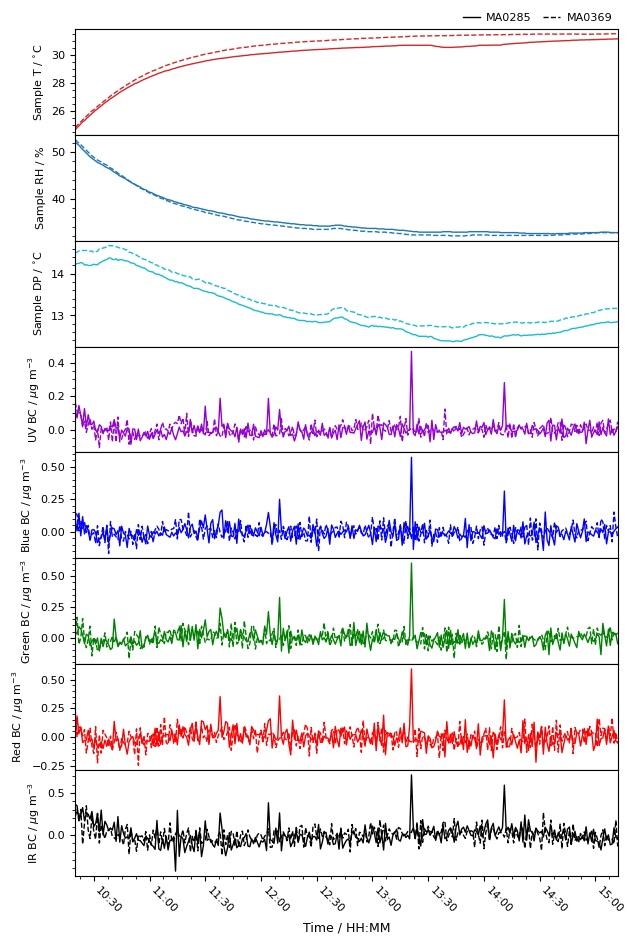

In [10]:
fig = plt.figure(figsize = (7, 11))
gs = fig.add_gridspec(8, hspace=0)
ax = gs.subplots(sharex=True)

for i, df_key in enumerate(conc_keys):
    for ls, dict_key in zip([line_styles[0], line_styles[2]], [HEPA_keys[0], HEPA_keys[2]]):
        plot_total(ax[i], corrected_HEPA[dict_key], df_key, colors[i], ls)
        ax[i].set_ylabel(ylabels[i], fontsize = 8)

ax[7].legend(labels = ['MA0285', 'MA0369'], bbox_to_anchor = (0, 7.2, 1, 1), ncol = 3, fontsize = 8)

fig.tight_layout()
fig.savefig('MA200/corrected_HEPA_timeseries.png', dpi = 600)